In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [19]:
df_url = "https://raw.githubusercontent.com/EZags/Milliman-Project-2025/main/merged_df1.csv"
df = pd.read_csv(df_url)
#Drop non-numeric columns
df

,county_state,fips,population,dep_prevalence,Households Total,Households Mean income (dollars),Households Median income (dollars),Premature Death Deaths,Premature Death Years of Potential Life Lost Rate,Poor Physical Health Days Average Number of Physically Unhealthy Days,...,Unemployment % Unemployed,Income Inequality 80th Percentile Income,Income Inequality 20th Percentile Income,Income Inequality Income Ratio,Children in Poverty % Children in Poverty,Injury Deaths # Injury Deaths,Injury Deaths Injury Death Rate,Social Associations # Associations,Social Associations Social Association Rate,Child Care Cost Burden % Household Income Required for Child Care Expenses
0,"AUTAUGA COUNTY, ALABAMA",1001,60436,18,NaN,NaN,NaN,1008.0,9938.263382,4.300364,...,2.188889,132562.0,31018.0,4.273712,17.0,189.0,65.975725,67.0,11.211700,21.835108
1,"BALDWIN COUNTY, ALABAMA",1003,254107,18,105698.0,98279.0,72915.0,3944.0,8957.112686,3.876436,...,2.279497,141920.0,32554.0,4.359526,14.1,953.0,82.420053,239.0,9.698298,19.354057
2,"BARBOUR COUNTY, ALABAMA",1005,24644,19,NaN,NaN,NaN,587.0,12738.656137,5.431030,...,4.431017,99138.0,17658.0,5.614339,34.8,106.0,85.603993,22.0,8.904720,28.579628
3,"BIBB COUNTY, ALABAMA",1007,21890,24,NaN,NaN,NaN,509.0,11708.948038,5.055619,...,2.462380,102593.0,19188.0,5.346727,21.4,111.0,99.630201,19.0,8.634401,26.582776
4,"BLOUNT COUNTY, ALABAMA",1009,59777,22,NaN,NaN,NaN,1273.0,11898.088409,4.802400,...,2.144295,117729.0,25484.0,4.619722,16.6,287.0,98.254695,44.0,7.393467,25.313260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,"VEGA BAJA MUNICIPIO, PUERTO RICO",72145,0,18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3237,"VIEQUES MUNICIPIO, PUERTO RICO",72147,0,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,"VILLALBA MUNICIPIO, PUERTO RICO",72149,0,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,"YABUCOA MUNICIPIO, PUERTO RICO",72151,0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np # Or pandas for DataFrames

# Let's assume you have your features (X) and target variable (y)
# For demonstration, I'll create some dummy data:
# X could be a NumPy array or a Pandas DataFrame
# y could be a NumPy array or a Pandas Series

# Example: 100 samples, 5 features
X = df.drop(columns=['dep_prevalence']) # Replace 'target_column_name' with your actual target column name
# Example: 100 target labels (e.g., for classification or regression)
y = df["dep_prevalence"] # Binary classification example

# Now, let's perform the split:
# X_train: Features for training
# X_test: Features for testing
# y_train: Target variable for training
# y_test: Target variable for testing
X_train, X_test, y_train, y_test = train_test_split(
    X,                       # Your features
    y,                       # Your target variable
    test_size=0.2,           # Proportion of the dataset to include in the test split (e.g., 0.2 for 20%)
    random_state=42,         # Controls the shuffling applied to the data before applying the split.           
)

# You can then check the shapes of your new datasets:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# If you're using pandas DataFrames:
# import pandas as pd
# X_X_train = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
# y_s = pd.Series(y, name='target')
#
# X_train_X_train, X_test_X_train, y_train_s, y_test_s = train_test_split(
#     X_X_train,
#     y_s,
#     test_size=0.2,
#     random_state=42,
#     stratify=y_s # if y_s is your target Series
# )
# print("\nUsing Pandas:")
# print("Shape of X_test_X_train:", X_train_X_train.shape)
# print("Shape of X_test_X_train:", X_test_X_train.shape)


Shape of X_train: (2592, 58)
Shape of X_test: (649, 58)
Shape of y_train: (2592,)
Shape of y_test: (649,)


In [ ]:
#Split the county_state column into two separate columns
X_train[['county', 'state']] = X_train['county_state'].str.split(',', expand=True)
#Drop the original county_state column
X_train.drop(columns=['county_state'], inplace=True)
#Drop the word county from the county column
X_train['county'] = X_train['county'].str.replace(' COUNTY', '')
#Move the county and state columns to the front of the dataframe
X_train = X_train[['county', 'state'] + [col for col in X_train.columns if col not in ['county', 'state']]]
#Drop any rows with missing values in the state or county columns
X_train.dropna(subset=['county', 'state'], inplace=True)
X_train.head()

#Split the county_state column into two separate columns
X_test[['county', 'state']] = X_test['county_state'].str.split(',', expand=True)
#Drop the original county_state column
X_test.drop(columns=['county_state'], inplace=True)
#Drop the word county from the county column
X_test['county'] = X_test['county'].str.replace(' COUNTY', '')
#Move the county and state columns to the front of the dataframe
X_test = X_test[['county', 'state'] + [col for col in X_test.columns if col not in ['county', 'state']]]
#Drop any rows with missing values in the state or county columns
X_test.dropna(subset=['county', 'state'], inplace=True)
X_test.head()

,county,state,fips,population,Households Total,Households Mean income (dollars),Households Median income (dollars),Premature Death Deaths,Premature Death Years of Potential Life Lost Rate,Poor Physical Health Days Average Number of Physically Unhealthy Days,...,Unemployment % Unemployed,Income Inequality 80th Percentile Income,Income Inequality 20th Percentile Income,Income Inequality Income Ratio,Children in Poverty % Children in Poverty,Injury Deaths # Injury Deaths,Injury Deaths Injury Death Rate,Social Associations # Associations,Social Associations Social Association Rate,Child Care Cost Burden % Household Income Required for Child Care Expenses
2936,BRISTOL CITY,VIRGINIA,51520,16668,NaN,NaN,NaN,432.0,12792.804640,4.967534,...,3.653027,103528.0,17567.0,5.893323,31.0,95.0,112.290490,34.0,20.029455,26.467728
840,KOSSUTH,IOWA,19109,14410,NaN,NaN,NaN,223.0,7363.981075,3.868272,...,2.485451,117107.0,29657.0,3.948714,12.3,58.0,79.013691,31.0,21.416235,23.530382
1174,WEST CARROLL PARISH,LOUISIANA,22123,9307,NaN,NaN,NaN,239.0,12773.807622,5.298902,...,6.213873,102240.0,19540.0,5.232344,30.3,59.0,114.503076,20.0,21.108179,31.356581
1618,GALLATIN,MONTANA,30031,125929,54621.0,124098.0,91158.0,797.0,4276.043188,3.434077,...,2.098864,166413.0,39992.0,4.161157,5.8,337.0,57.052309,147.0,11.773469,28.994304
2656,HUNT,TEXAS,48231,113754,40067.0,98988.0,71045.0,1948.0,10488.820931,4.399847,...,4.135011,126932.0,31814.0,3.989816,17.1,391.0,77.185779,107.0,9.881605,28.011984


Imputation

In [ ]:
#Determine the number of missing values in each column
missing_values = X_train.isnull().sum()
missing_values
#Determine the percentage of missing values in each column
missing_percentage = (missing_values / len(X_train)) * 100
missing_percentage
#Determine the missing values in each column for the state of Connecticut
missing_values_ct = X_train[X_train['state'] == 'CONNECTICUT'].isnull().sum()
missing_values_ct

#Determine the number of missing values in each column
missing_values1 = X_test.isnull().sum()
missing_values1
#Determine the percentage of missing values in each column
missing_percentage1 = (missing_values / len(X_test)) * 100
missing_percentage1
#Determine the missing values in each column for the state of Connecticut
missing_values_ct1 = X_test[X_test['state'] == 'CONNECTICUT'].isnull().sum()
missing_values_ct1

county                                                                           0
state                                                                            0
fips                                                                             0
population                                                                       0
Households Total                                                              1885
Households Mean income (dollars)                                              1885
Households Median income (dollars)                                            1885
Premature Death Deaths                                                         248
Premature Death Years of Potential Life Lost Rate                              248
Poor Physical Health Days Average Number of Physically Unhealthy Days           76
Low Birth Weight % Low Birth Weight                                            140
Poor Mental Health Days Average Number of Mentally Unhealthy Days               76
Poor

county                                                                         0.000000
state                                                                          0.000000
fips                                                                           0.000000
population                                                                     0.000000
Households Total                                                              73.546625
Households Mean income (dollars)                                              73.546625
Households Median income (dollars)                                            73.546625
Premature Death Deaths                                                         9.676161
Premature Death Years of Potential Life Lost Rate                              9.676161
Poor Physical Health Days Average Number of Physically Unhealthy Days          2.965275
Low Birth Weight % Low Birth Weight                                            5.462349
Poor Mental Health Days Average 

county                                                                        0
state                                                                         0
fips                                                                          0
population                                                                    0
Households Total                                                              0
Households Mean income (dollars)                                              0
Households Median income (dollars)                                            0
Premature Death Deaths                                                        0
Premature Death Years of Potential Life Lost Rate                             0
Poor Physical Health Days Average Number of Physically Unhealthy Days         0
Low Birth Weight % Low Birth Weight                                           0
Poor Mental Health Days Average Number of Mentally Unhealthy Days             0
Poor or Fair Health % Fair or Poor Healt

In [ ]:
#Clear any whitespace from the state and county columns
X_train['state'] = X_train['state'].str.strip()
X_test['state'] = X_test['state'].str.strip()
#Defines the four regions of the US
regions = {
    'Northeast': ['CONNECTICUT', 'MAINE', 'MASSACHUSETTS', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW YORK', 'PENNSYLVANIA', 'RHODE ISLAND', 'VERMONT'],
    'Midwest': ['ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'OHIO', 'SOUTH DAKOTA', 'WISCONSIN'],
    'South': ['ALABAMA', 'ARKANSAS', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'MISSISSIPPI', 'NORTH CAROLINA',
              'OKLAHOMA', 'SOUTH CAROLINA', 'TENNESSEE', 'TEXAS', 'VIRGINIA', 'WEST VIRGINIA'],
    'West': ['ALASKA', 'ARIZONA', 'CALIFORNIA', 'COLORADO', 'HAWAII', 'IDAHO', 'MONTANA', 'NEVADA',
             'NEW MEXICO','OREGON','UTAH','WASHINGTON','WYOMING']
}
#Create a new column called region and assign the region based on the state in the state column
state_to_region = {state: region for region, states in regions.items() for state in states}
X_train['region'] = X_train['state'].map(state_to_region)
#Convert the region column to a categorical variable
X_train['region'] = X_train['region'].astype('category')
#Convert the state column to a categorical variable
X_train['state'] = X_train['state'].astype('category')
#Convert the county column to a categorical variable
X_train['county'] = X_train['county'].astype('category')
#Move the region column to the front of the dataframe
X_train = X_train[['county', 'state', 'region'] + [col for col in X_train.columns if col not in ['region', 'county', 'state']]]
X_train.head()

X_test['region'] = X_test['state'].map(state_to_region)
#Convert the region column to a categorical variable
X_test['region'] = X_test['region'].astype('category')
#Convert the state column to a categorical variable
X_test['state'] = X_test['state'].astype('category')
#Convert the county column to a categorical variable
X_test['county'] = X_test['county'].astype('category')
#Move the region column to the front of the dataframe
X_test = X_test[['county', 'state', 'region'] + [col for col in X_test.columns if col not in ['region', 'county', 'state']]]
X_test.head()

,county,state,region,fips,population,Households Total,Households Mean income (dollars),Households Median income (dollars),Premature Death Deaths,Premature Death Years of Potential Life Lost Rate,...,Unemployment % Unemployed,Income Inequality 80th Percentile Income,Income Inequality 20th Percentile Income,Income Inequality Income Ratio,Children in Poverty % Children in Poverty,Injury Deaths # Injury Deaths,Injury Deaths Injury Death Rate,Social Associations # Associations,Social Associations Social Association Rate,Child Care Cost Burden % Household Income Required for Child Care Expenses
2936,BRISTOL CITY,VIRGINIA,South,51520,16668,NaN,NaN,NaN,432.0,12792.804640,...,3.653027,103528.0,17567.0,5.893323,31.0,95.0,112.290490,34.0,20.029455,26.467728
840,KOSSUTH,IOWA,Midwest,19109,14410,NaN,NaN,NaN,223.0,7363.981075,...,2.485451,117107.0,29657.0,3.948714,12.3,58.0,79.013691,31.0,21.416235,23.530382
1174,WEST CARROLL PARISH,LOUISIANA,South,22123,9307,NaN,NaN,NaN,239.0,12773.807622,...,6.213873,102240.0,19540.0,5.232344,30.3,59.0,114.503076,20.0,21.108179,31.356581
1618,GALLATIN,MONTANA,West,30031,125929,54621.0,124098.0,91158.0,797.0,4276.043188,...,2.098864,166413.0,39992.0,4.161157,5.8,337.0,57.052309,147.0,11.773469,28.994304
2656,HUNT,TEXAS,South,48231,113754,40067.0,98988.0,71045.0,1948.0,10488.820931,...,4.135011,126932.0,31814.0,3.989816,17.1,391.0,77.185779,107.0,9.881605,28.011984


In [ ]:
#A function that imputes the mean of a column and fills in the missing values with the mean
def impute_mean(X_train1, column):
    mean_value = X_train1[column].mean()
    X_train1[column].fillna(mean_value, inplace=True)
    return X_train1

#A function that imputes using KNN
def impute_knn(X_train_1, column):
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train_1[column] = knn_imputer.fit_transform(X_train_1[[column]])
    return X_train_1

#Drops all columns in X_train with over 40% missing values
X_train.drop(columns=missing_percentage[missing_percentage > 40].index, inplace=True)

#Iterate through the missing values dataframe choosing columns with a missing percentage < 5% for mean imputation and > 5% for KNN imputation, make sure only numeric columns are selected
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
missing_percentage = missing_percentage[missing_percentage.index.isin(numeric_columns)]
for column in missing_percentage[missing_percentage < 5].index:
    X_train = impute_mean(X_train, column)
for column in missing_percentage[missing_percentage > 5].index:
    X_train = impute_knn(X_train, column)

#Change settings to display all columns in the dataframe
pd.set_option('display.max_columns', None)

#Check for any remaining missing values
missing_values = X_train.isnull().sum()
missing_values


#Now on the X_test dataset

#A function that imputes the mean of a column and fills in the missing values with the mean
def impute_mean(X_test1, column):
    mean_value = X_test1[column].mean()
    X_test1[column].fillna(mean_value, inplace=True)
    return X_test1

#A function that imputes using KNN
def impute_knn(X_test_1, column):
    knn_imputer = KNNImputer(n_neighbors=5)
    X_test_1[column] = knn_imputer.fit_transform(X_test_1[[column]])
    return X_test_1

#Drops all columns in X_test with over 40% missing values
X_test.drop(columns=missing_percentage[missing_percentage > 40].index, inplace=True)

#Iterate through the missing values dataframe choosing columns with a missing percentage < 5% for mean imputation and > 5% for KNN imputation, make sure only numeric columns are selected
numeric_columns = X_test.select_dtypes(include=[np.number]).columns
missing_percentage = missing_percentage[missing_percentage.index.isin(numeric_columns)]
for column in missing_percentage[missing_percentage < 5].index:
    X_test = impute_mean(X_test, column)
for column in missing_percentage[missing_percentage > 5].index:
    X_test = impute_knn(X_test, column)

#Change settings to display all columns in the dataframe
pd.set_option('display.max_columns', None)

#Check for any remaining missing values
missing_values = X_test.isnull().sum()
missing_values

C:\Users\ezago\AppData\Local\Temp\ipykernel_10884\2322834441.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train1[column].fillna(mean_value, inplace=True)


county                                                                          0
state                                                                           0
region                                                                         65
fips                                                                            0
population                                                                      0
Premature Death Deaths                                                          0
Premature Death Years of Potential Life Lost Rate                               0
Poor Physical Health Days Average Number of Physically Unhealthy Days           0
Low Birth Weight % Low Birth Weight                                             0
Poor Mental Health Days Average Number of Mentally Unhealthy Days               0
Poor or Fair Health % Fair or Poor Health                                       0
Flu Vaccinations % Vaccinated                                                   0
Access to Exerci

In [ ]:
#Display rows with missing values in the 'region' column
X_train[X_train['region'].isnull()]
# Add 'Other' to the categories of the 'region' column
X_train['region'] = X_train['region'].cat.add_categories('Other')
# Fill these values with the word "Other"
X_train['region'].fillna('Other', inplace=True)
#Check for any remaining missing values
missing_values = X_train.isnull().sum()
missing_values

#Now on the X_test dataset

#Display rows with missing values in the 'region' column
X_test[X_test['region'].isnull()]
# Add 'Other' to the categories of the 'region' column
X_test['region'] = X_test['region'].cat.add_categories('Other')
# Fill these values with the word "Other"
X_test['region'].fillna('Other', inplace=True)
#Check for any remaining missing values
missing_values = X_test.isnull().sum()
missing_values

,county,state,region,fips,population,Premature Death Deaths,Premature Death Years of Potential Life Lost Rate,Poor Physical Health Days Average Number of Physically Unhealthy Days,Low Birth Weight % Low Birth Weight,Poor Mental Health Days Average Number of Mentally Unhealthy Days,Poor or Fair Health % Fair or Poor Health,Flu Vaccinations % Vaccinated,Access to Exercise Opportunities % With Access to Exercise Opportunities,Food Environment Index Food Environment Index,Primary Care Physicians # Primary Care Physicians,Primary Care Physicians Primary Care Physicians Rate,Primary Care Physicians Primary Care Physicians Ratio,Mental Health Providers # Mental Health Providers,Mental Health Providers Mental Health Provider Rate,Mental Health Providers Mental Health Provider Ratio,Dentists # Dentists,Dentists Dentist Rate,Dentists Dentist Ratio,Preventable Hospital Stays Preventable Hospitalization Rate,Mammography Screening % with Annual Mammogram,Uninsured # Uninsured,Uninsured % Uninsured,Severe Housing Problems % Severe Housing Problems,Severe Housing Problems Severe Housing Cost Burden,Severe Housing Problems Overcrowding,Severe Housing Problems Inadequate Facilities,Driving Alone to Work % Drive Alone to Work,Long Commute - Driving Alone # Workers who Drive Alone,Long Commute - Driving Alone % Long Commute - Drives Alone,Air Pollution: Particulate Matter Average Daily PM2.5,Drinking Water Violations Presence of Water Violation,Broadband Access % Households with Broadband Access,Broadband Access # Households with Broadband Access,Library Access Visits per service area population,Some College # Some College,Some College Population,Some College % Some College,High School Completion # Completed High School,High School Completion Population,High School Completion % Completed High School,Unemployment # Unemployed,Unemployment Labor Force,Unemployment % Unemployed,Income Inequality 80th Percentile Income,Income Inequality 20th Percentile Income,Income Inequality Income Ratio,Children in Poverty % Children in Poverty,Injury Deaths # Injury Deaths,Injury Deaths Injury Death Rate,Social Associations # Associations,Social Associations Social Association Rate,Child Care Cost Burden % Household Income Required for Child Care Expenses
3167,AGUADILLA MUNICIPIO,PUERTO RICO,NaN,72005,0,1602.124406,10502.759706,4.458946,8.413351,5.647373,19.592159,41.178571,61.917216,7.438986,80.475084,53.910657,NaN,346.072279,206.589195,NaN,76.653498,48.203628,NaN,2835.292723,42.914022,8120.04423,10.503499,12.718486,9.961657,2.296158,1.178728,77.213337,48075.766385,33.179292,7.65716,NaN,84.281582,34909.045838,2.584808,18118.304103,26924.235318,59.158355,62448.470446,69638.527141,88.74211,1833.797595,51446.614429,3.575204,124276.014159,28210.21966,4.569478,19.003498,446.233058,99.709495,90.021311,11.381524,28.613466
3193,GUAYANILLA MUNICIPIO,PUERTO RICO,NaN,72059,0,1602.124406,10502.759706,4.458946,8.413351,5.647373,19.592159,41.178571,61.917216,7.438986,80.475084,53.910657,NaN,346.072279,206.589195,NaN,76.653498,48.203628,NaN,2835.292723,42.914022,8120.04423,10.503499,12.718486,9.961657,2.296158,1.178728,77.213337,48075.766385,33.179292,7.65716,NaN,84.281582,34909.045838,2.584808,18118.304103,26924.235318,59.158355,62448.470446,69638.527141,88.74211,1833.797595,51446.614429,3.575204,124276.014159,28210.21966,4.569478,19.003498,446.233058,99.709495,90.021311,11.381524,28.613466
3236,VEGA BAJA MUNICIPIO,PUERTO RICO,NaN,72145,0,1602.124406,10502.759706,4.458946,8.413351,5.647373,19.592159,41.178571,61.917216,7.438986,80.475084,53.910657,NaN,346.072279,206.589195,NaN,76.653498,48.203628,NaN,2835.292723,42.914022,8120.04423,10.503499,12.718486,9.961657,2.296158,1.178728,77.213337,48075.766385,33.179292,7.65716,NaN,84.281582,34909.045838,2.584808,18118.304103,26924.235318,59.158355,62448.470446,69638.527141,88.74211,1833.797595,51446.614429,3.575204,124276.014159,28210.21966,4.569478,19.003498,446.233058,99.709495,90.021311,11.381524,28.613466
3194,GUAYNABO MUNICIPIO

C:\Users\ezago\AppData\Local\Temp\ipykernel_10884\1764935240.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['region'].fillna('Other', inplace=True)


county                                                                          0
state                                                                           0
region                                                                          0
fips                                                                            0
population                                                                      0
Premature Death Deaths                                                          0
Premature Death Years of Potential Life Lost Rate                               0
Poor Physical Health Days Average Number of Physically Unhealthy Days           0
Low Birth Weight % Low Birth Weight                                             0
Poor Mental Health Days Average Number of Mentally Unhealthy Days               0
Poor or Fair Health % Fair or Poor Health                                       0
Flu Vaccinations % Vaccinated                                                   0
Access to Exerci

In [ ]:
#Drop all columns that contain the word "Ratio" in the column name
X_train.drop(columns=[col for col in X_train.columns if 'Ratio' in col], inplace=True)

#Now on the X_test dataset

#Drop all columns that contain the word "Ratio" in the column name
X_test.drop(columns=[col for col in X_test.columns if 'Ratio' in col], inplace=True)

In [ ]:
#Transform the "Drinking Water Violations" column to a categorical variable
X_train['Drinking Water Violations Presence of Water Violation'] = X_train['Drinking Water Violations Presence of Water Violation'].astype('category')
#One hot encode that column
X_train = pd.get_dummies(X_train, columns=['Drinking Water Violations Presence of Water Violation'], drop_first=True)
X_train

#Now on the X_test dataset

#Transform the "Drinking Water Violations" column to a categorical variable
X_test['Drinking Water Violations Presence of Water Violation'] = X_test['Drinking Water Violations Presence of Water Violation'].astype('category')
#One hot encode that column
X_test = pd.get_dummies(X_test, columns=['Drinking Water Violations Presence of Water Violation'], drop_first=True)
X_test

,county,state,region,fips,population,Premature Death Deaths,Premature Death Years of Potential Life Lost Rate,Poor Physical Health Days Average Number of Physically Unhealthy Days,Low Birth Weight % Low Birth Weight,Poor Mental Health Days Average Number of Mentally Unhealthy Days,Poor or Fair Health % Fair or Poor Health,Flu Vaccinations % Vaccinated,Access to Exercise Opportunities % With Access to Exercise Opportunities,Food Environment Index Food Environment Index,Primary Care Physicians # Primary Care Physicians,Primary Care Physicians Primary Care Physicians Rate,Mental Health Providers # Mental Health Providers,Mental Health Providers Mental Health Provider Rate,Dentists # Dentists,Dentists Dentist Rate,Preventable Hospital Stays Preventable Hospitalization Rate,Mammography Screening % with Annual Mammogram,Uninsured # Uninsured,Uninsured % Uninsured,Severe Housing Problems % Severe Housing Problems,Severe Housing Problems Severe Housing Cost Burden,Severe Housing Problems Overcrowding,Severe Housing Problems Inadequate Facilities,Driving Alone to Work % Drive Alone to Work,Long Commute - Driving Alone # Workers who Drive Alone,Long Commute - Driving Alone % Long Commute - Drives Alone,Air Pollution: Particulate Matter Average Daily PM2.5,Broadband Access % Households with Broadband Access,Broadband Access # Households with Broadband Access,Library Access Visits per service area population,Some College # Some College,Some College Population,Some College % Some College,High School Completion # Completed High School,High School Completion Population,High School Completion % Completed High School,Unemployment # Unemployed,Unemployment Labor Force,Unemployment % Unemployed,Income Inequality 80th Percentile Income,Income Inequality 20th Percentile Income,Children in Poverty % Children in Poverty,Injury Deaths # Injury Deaths,Injury Deaths Injury Death Rate,Social Associations # Associations,Social Associations Social Association Rate,Child Care Cost Burden % Household Income Required for Child Care Expenses,Drinking Water Violations Presence of Water Violation_Yes
2936,BRISTOL CITY,VIRGINIA,South,51520,16668,432.000000,12792.804640,4.967534,8.627451,6.314123,21.200000,51.000000,91.178349,6.400000,11.000000,64.501000,23.000000,136.847740,6.000000,35.346100,3766.000000,48.000000,1025.00000,7.931595,14.771954,13.392857,1.429544,0.000000,79.142462,7230.000000,16.000000,6.00000,75.979255,5567.000000,7.896463,2351.000000,4074.000000,57.707413,10947.000000,12224.000000,89.553338,283.000000,7747.000000,3.653027,103528.000000,17567.00000,31.000000,95.000000,112.290490,34.000000,20.029455,26.467728,False
840,KOSSUTH,IOWA,Midwest,19109,14410,223.000000,7363.981075,3.868272,4.995693,5.058546,16.100000,39.000000,61.404100,8.600000,7.000000,48.179500,9.000000,62.517370,8.000000,55.267700,3151.000000,58.000000,579.00000,5.392568,10.124611,8.796223,0.498442,1.246106,78.181559,7017.000000,19.100000,6.90000,86.742541,5640.000000,5.466872,2089.000000,3075.000000,67.934959,9829.000000,10381.000000,94.682593,205.000000,8248.000000,2.485451,117107.000000,29657.00000,12.300000,58.000000,79.013691,31.000000,21.416235,23.530382,False
1174,WEST CARROLL PARISH,LOUISIANA,South,22123,9307,239.000000,12773.807622,5.298902,10.178117,6.697984,26.500000,30.000000,31.607015,7.300000,5.000000,52.115910,6.000000,64.356970,2.000000,21.108180,6751.000000,39.000000,672.00000,9.008043,10.540541,7.569061,2.027027,1.216216,88.343390,3646.000000,34.400000,8.30000,63.845161,2474.000000,1.147018,883.000000,2313.000000,38.175530,5623.000000,6719.000000,83.688049,215.000000,3460.000000,6.213873,102240.000000,19540.00000,30.300000,59.000000,114.503076,20.000000,21.108179,31.356581,True
1618,GALLATIN,MONTANA,West,30031,125929,797.000000,4276.043188,3.434077,7.466311,5.058686,12.700000,50.000000,86.846839,9.100000,96.000000,78.231320,603.000000,477.023000,87.000000,69.679710,1495.000000,48.000000,8451.00000,8.035027,14.801639,13.245538,1.412247,0.388098,68.135662,68936.0000

In [ ]:
X_train.drop(columns=["Premature Death Years of Potential Life Lost Rate", 
                "Primary Care Physicians Primary Care Physicians Rate",
                "Mental Health Providers Mental Health Provider Rate",
                "Dentists Dentist Rate",
                "Uninsured # Uninsured",
                "Severe Housing Problems Severe Housing Cost Burden",
                "Severe Housing Problems Overcrowding",
                "Severe Housing Problems Inadequate Facilities",
                "Long Commute - Driving Alone # Workers who Drive Alone",
                "Air Pollution: Particulate Matter Average Daily PM2.5",
                "Broadband Access # Households with Broadband Access",
                "Some College # Some College",
                "Some College Population",
                "High School Completion # Completed High School",
                "High School Completion Population",
                "Unemployment # Unemployed",
                "Unemployment Labor Force",
                "Income Inequality 80th Percentile Income",
                "Income Inequality 20th Percentile Income",
                "Injury Deaths Injury Death Rate",
                "Social Associations Social Association Rate"], inplace=True)


#Now on the X_test dataset

X_test.drop(columns=["Premature Death Years of Potential Life Lost Rate", 
                "Primary Care Physicians Primary Care Physicians Rate",
                "Mental Health Providers Mental Health Provider Rate",
                "Dentists Dentist Rate",
                "Uninsured # Uninsured",
                "Severe Housing Problems Severe Housing Cost Burden",
                "Severe Housing Problems Overcrowding",
                "Severe Housing Problems Inadequate Facilities",
                "Long Commute - Driving Alone # Workers who Drive Alone",
                "Air Pollution: Particulate Matter Average Daily PM2.5",
                "Broadband Access # Households with Broadband Access",
                "Some College # Some College",
                "Some College Population",
                "High School Completion # Completed High School",
                "High School Completion Population",
                "Unemployment # Unemployed",
                "Unemployment Labor Force",
                "Income Inequality 80th Percentile Income",
                "Income Inequality 20th Percentile Income",
                "Injury Deaths Injury Death Rate",
                "Social Associations Social Association Rate"], inplace=True)

In [ ]:
X_train["Premature Death %"] = X_train["Premature Death Deaths"] / X_train["population"] * 100
X_train["Primary Care Physicians %"] = X_train["Primary Care Physicians # Primary Care Physicians"] / X_train["population"] * 100
X_train["Injury Deaths %"] = X_train["Injury Deaths # Injury Deaths"] / X_train["population"] * 100
X_train.drop(columns=["Premature Death Deaths",
                "Primary Care Physicians # Primary Care Physicians",
                "Injury Deaths # Injury Deaths"], inplace=True)


#Now on the X_test dataset

X_test["Premature Death %"] = X_test["Premature Death Deaths"] / X_test["population"] * 100
X_test["Primary Care Physicians %"] = X_test["Primary Care Physicians # Primary Care Physicians"] / X_test["population"] * 100
X_test["Injury Deaths %"] = X_test["Injury Deaths # Injury Deaths"] / X_test["population"] * 100
X_test.drop(columns=["Premature Death Deaths",
                "Primary Care Physicians # Primary Care Physicians",
                "Injury Deaths # Injury Deaths"], inplace=True)

In [ ]:
X_train["south"] = X_train["region"].apply(lambda x: 1 if x == "South" else 0)
X_train["midwest"] = X_train["region"].apply(lambda x: 1 if x == "Midwest" else 0)
X_train["northeast"] = X_train["region"].apply(lambda x: 1 if x == "Northeast" else 0)
X_train["west"] = X_train["region"].apply(lambda x: 1 if x == "West" else 0)
X_train.drop(columns=["region"], inplace=True)
X_train.drop(columns=["county", "state"], inplace=True)

#Now on the X_test dataset

X_test["south"] = X_test["region"].apply(lambda x: 1 if x == "South" else 0)
X_test["midwest"] = X_test["region"].apply(lambda x: 1 if x == "Midwest" else 0)
X_test["northeast"] = X_test["region"].apply(lambda x: 1 if x == "Northeast" else 0)
X_test["west"] = X_test["region"].apply(lambda x: 1 if x == "West" else 0)
X_test.drop(columns=["region"], inplace=True)
X_test.drop(columns=["county", "state"], inplace=True)

In [ ]:
X_train["Social Associations per 1000"] = X_train["Social Associations # Associations"] / X_train["population"] * 1000
X_train["Mental Health Providers per 1000"] = X_train["Mental Health Providers # Mental Health Providers"] / X_train["population"] * 1000
X_train["Dentists per 1000"] = X_train["Dentists # Dentists"] / X_train["population"] * 1000
X_train.drop(columns=["Social Associations # Associations",
                "Mental Health Providers # Mental Health Providers",
                "Dentists # Dentists",
                "population",
                "fips"], inplace=True)
#Drop rows if the value in any of the new columns is greater than 1000000000000000
X_train = X_train[(X_train["Social Associations per 1000"] < 1000000000000000) & 
        (X_train["Mental Health Providers per 1000"] < 1000000000000000) & 
        (X_train["Dentists per 1000"] < 1000000000000000)]


#Now on the X_test dataset

X_test["Social Associations per 1000"] = X_test["Social Associations # Associations"] / X_test["population"] * 1000
X_test["Mental Health Providers per 1000"] = X_test["Mental Health Providers # Mental Health Providers"] / X_test["population"] * 1000
X_test["Dentists per 1000"] = X_test["Dentists # Dentists"] / X_test["population"] * 1000
X_test.drop(columns=["Social Associations # Associations",
                "Mental Health Providers # Mental Health Providers",
                "Dentists # Dentists",
                "population",
                "fips"], inplace=True)
#Drop rows if the value in any of the new columns is greater than 1000000000000000
X_test = X_test[(X_test["Social Associations per 1000"] < 1000000000000000) & 
        (X_test["Mental Health Providers per 1000"] < 1000000000000000) & 
        (X_test["Dentists per 1000"] < 1000000000000000)]

In [ ]:
#Standardize all columns with a % in the name
X_train.loc[:, X_train.columns.str.contains('%')] = X_train.loc[:, X_train.columns.str.contains('%')].apply(lambda x: x / 100)
X_train

#Now on the X_test dataset

#Standardize all columns with a % in the name
X_test.loc[:, X_test.columns.str.contains('%')] = X_test.loc[:, X_test.columns.str.contains('%')].apply(lambda x: x / 100)
X_test

,Poor Physical Health Days Average Number of Physically Unhealthy Days,Low Birth Weight % Low Birth Weight,Poor Mental Health Days Average Number of Mentally Unhealthy Days,Poor or Fair Health % Fair or Poor Health,Flu Vaccinations % Vaccinated,Access to Exercise Opportunities % With Access to Exercise Opportunities,Food Environment Index Food Environment Index,Preventable Hospital Stays Preventable Hospitalization Rate,Mammography Screening % with Annual Mammogram,Uninsured % Uninsured,Severe Housing Problems % Severe Housing Problems,Driving Alone to Work % Drive Alone to Work,Long Commute - Driving Alone % Long Commute - Drives Alone,Broadband Access % Households with Broadband Access,Library Access Visits per service area population,Some College % Some College,High School Completion % Completed High School,Unemployment % Unemployed,Children in Poverty % Children in Poverty,Child Care Cost Burden % Household Income Required for Child Care Expenses,Drinking Water Violations Presence of Water Violation_Yes,Premature Death %,Primary Care Physicians %,Injury Deaths %,south,midwest,northeast,west,Social Associations per 1000,Mental Health Providers per 1000,Dentists per 1000
2936,4.967534,0.086275,6.314123,0.212,0.51,0.911783,6.4,3766.0,0.48,0.079316,0.147720,0.791425,0.160,0.759793,7.896463,0.577074,0.895533,0.036530,0.310,0.264677,False,0.025918,0.000660,0.005700,1,0,0,0,2.039837,1.379890,0.359971
840,3.868272,0.049957,5.058546,0.161,0.39,0.614041,8.6,3151.0,0.58,0.053926,0.101246,0.781816,0.191,0.867425,5.466872,0.679350,0.946826,0.024855,0.123,0.235304,False,0.015475,0.000486,0.004025,0,1,0,0,2.151284,0.624566,0.555170
1174,5.298902,0.101781,6.697984,0.265,0.30,0.316070,7.3,6751.0,0.39,0.090080,0.105405,0.883434,0.344,0.638452,1.147018,0.381755,0.836880,0.062139,0.303,0.313566,True,0.025680,0.000537,0.006339,1,0,0,0,2.148920,0.644676,0.214892
1618,3.434077,0.074663,5.058686,0.127,0.50,0.868468,9.1,1495.0,0.48,0.080350,0.148016,0.681357,0.160,0.922968,1.979517,0.803054,0.971642,0.020989,0.058,0.289943,False,0.006329,0.000762,0.002676,0,0,0,1,1.167324,4.788413,0.690865
2656,4.399847,0.083260,5.895563,0.206,0.40,0.609418,7.1,4436.0,0.42,0.189006,0.177737,0.783554,0.434,0.876801,0.921351,0.555324,0.863177,0.041350,0.171,0.280120,True,0.017125,0.000246,0.003437,1,0,0,0,0.940626,0.852717,0.298891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,4.204037,0.074746,5.676396,0.208,0.53,0.656115,8.6,952.0,0.53,0.086836,0.114590,0.763066,0.348,0.831143,4.802728,0.602112,0.915102,0.034112,0.147,0.335839,False,0.015244,0.000824,0.004532,0,1,0,0,1.493537,1.030025,0.566514
1095,5.281015,0.081289,5.707874,0.293,0.30,0.625368,7.0,2629.0,0.45,0.075298,0.110315,0.853107,0.255,0.804854,1.639944,0.519098,0.817884,0.053213,0.251,0.212883,True,0.024634,0.000382,0.005353,1,0,0,0,0.928556,1.911733,0.273105
1130,6.396404,0.157197,7.026125,0.363,0.17,0.847030,4.2,8444.0,0.46,0.087907,0.205418,0.781352,0.168,0.671451,0.860658,0.285644,0.690745,0.087938,0.528,0.426165,True,0.026312,0.000436,0.004361,1,0,0,0,0.872220,5.233319,0.290740
1294,4.481129,0.078984,5.764475,0.180,0.32,0.813518,7.8,2308.0,0.47,0.070471,0.127845,0.774371,0.440,0.826590,2.657047,0.541509,0.897471,0.042965,0.179,0.267276,False,0.015726,0.000352,0.005099,0,1,0,0,1.230733,2.246576,0.566528


In [ ]:
#import boxcox and yeo-johnson from scipy
from scipy import stats
#Run a box-cox transformation if the column has a skewness > 0.5 or <-0.5 and is all positive values, if only the skewness is > 0.5 or < -0.5 then run a yeo-johnson transformation
#Only include numeric columns, skipping the first column
numeric_columns = X_train.select_dtypes(include=[np.number]).columns[1:]
for column in numeric_columns:
    if X_train[column].skew() > 0.5 and (X_train[column] > 0).all():
        X_train[column], _ = stats.boxcox(X_train[column])
    elif X_train[column].skew() < -0.5:
        X_train[column] = stats.yeojohnson(X_train[column])[0]
    else:
        pass
#Check the skewness of the columns after transformation
X_train.skew()

#Now on the X_test dataset

#Run a box-cox transformation if the column has a skewness > 0.5 or <-0.5 and is all positive values, if only the skewness is > 0.5 or < -0.5 then run a yeo-johnson transformation
#Only include numeric columns, skipping the first column
numeric_columns = X_test.select_dtypes(include=[np.number]).columns[1:]
for column in numeric_columns:
    if X_test[column].skew() > 0.5 and (X_test[column] > 0).all():
        X_test[column], _ = stats.boxcox(X_test[column])
    elif X_test[column].skew() < -0.5:
        X_test[column] = stats.yeojohnson(X_test[column])[0]
    else:
        pass
#Check the skewness of the columns after transformation
X_test.skew()

C:\Users\ezago\AppData\Local\Temp\ipykernel_10884\3841848567.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column], _ = stats.boxcox(X_train[column])
C:\Users\ezago\AppData\Local\Temp\ipykernel_10884\3841848567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = stats.yeojohnson(X_train[column])[0]


Poor Physical Health Days Average Number of Physically Unhealthy Days         0.312512
Low Birth Weight % Low Birth Weight                                          -0.008969
Poor Mental Health Days Average Number of Mentally Unhealthy Days             0.050322
Poor or Fair Health % Fair or Poor Health                                     0.002703
Flu Vaccinations % Vaccinated                                                -0.428086
Access to Exercise Opportunities % With Access to Exercise Opportunities     -0.082448
Food Environment Index Food Environment Index                                -0.056907
Preventable Hospital Stays Preventable Hospitalization Rate                   0.065013
Mammography Screening % with Annual Mammogram                                -0.338810
Uninsured % Uninsured                                                         0.001400
Severe Housing Problems % Severe Housing Problems                             0.045268
Driving Alone to Work % Drive Alone to Work

In [34]:
# Log transform the columns with a skewness > 0.5 or <-0.5 and are all positive values
for column in numeric_columns:
    if X_train[column].skew() > 0.5 and (X_train[column] > 0).all():
        X_train.loc[:, column] = np.log1p(X_train[column])
    elif X_train[column].skew() < -0.5:
        X_train.loc[:, column] = stats.yeojohnson(X_train[column])[0]

# Min-max scale the columns with values > 1
for column in numeric_columns:
    if X_train[column].max() > 1:
        X_train.loc[:, column] = (X_train[column] - X_train[column].min()) / (X_train[column].max() - X_train[column].min())

<Figure size 2000x2000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

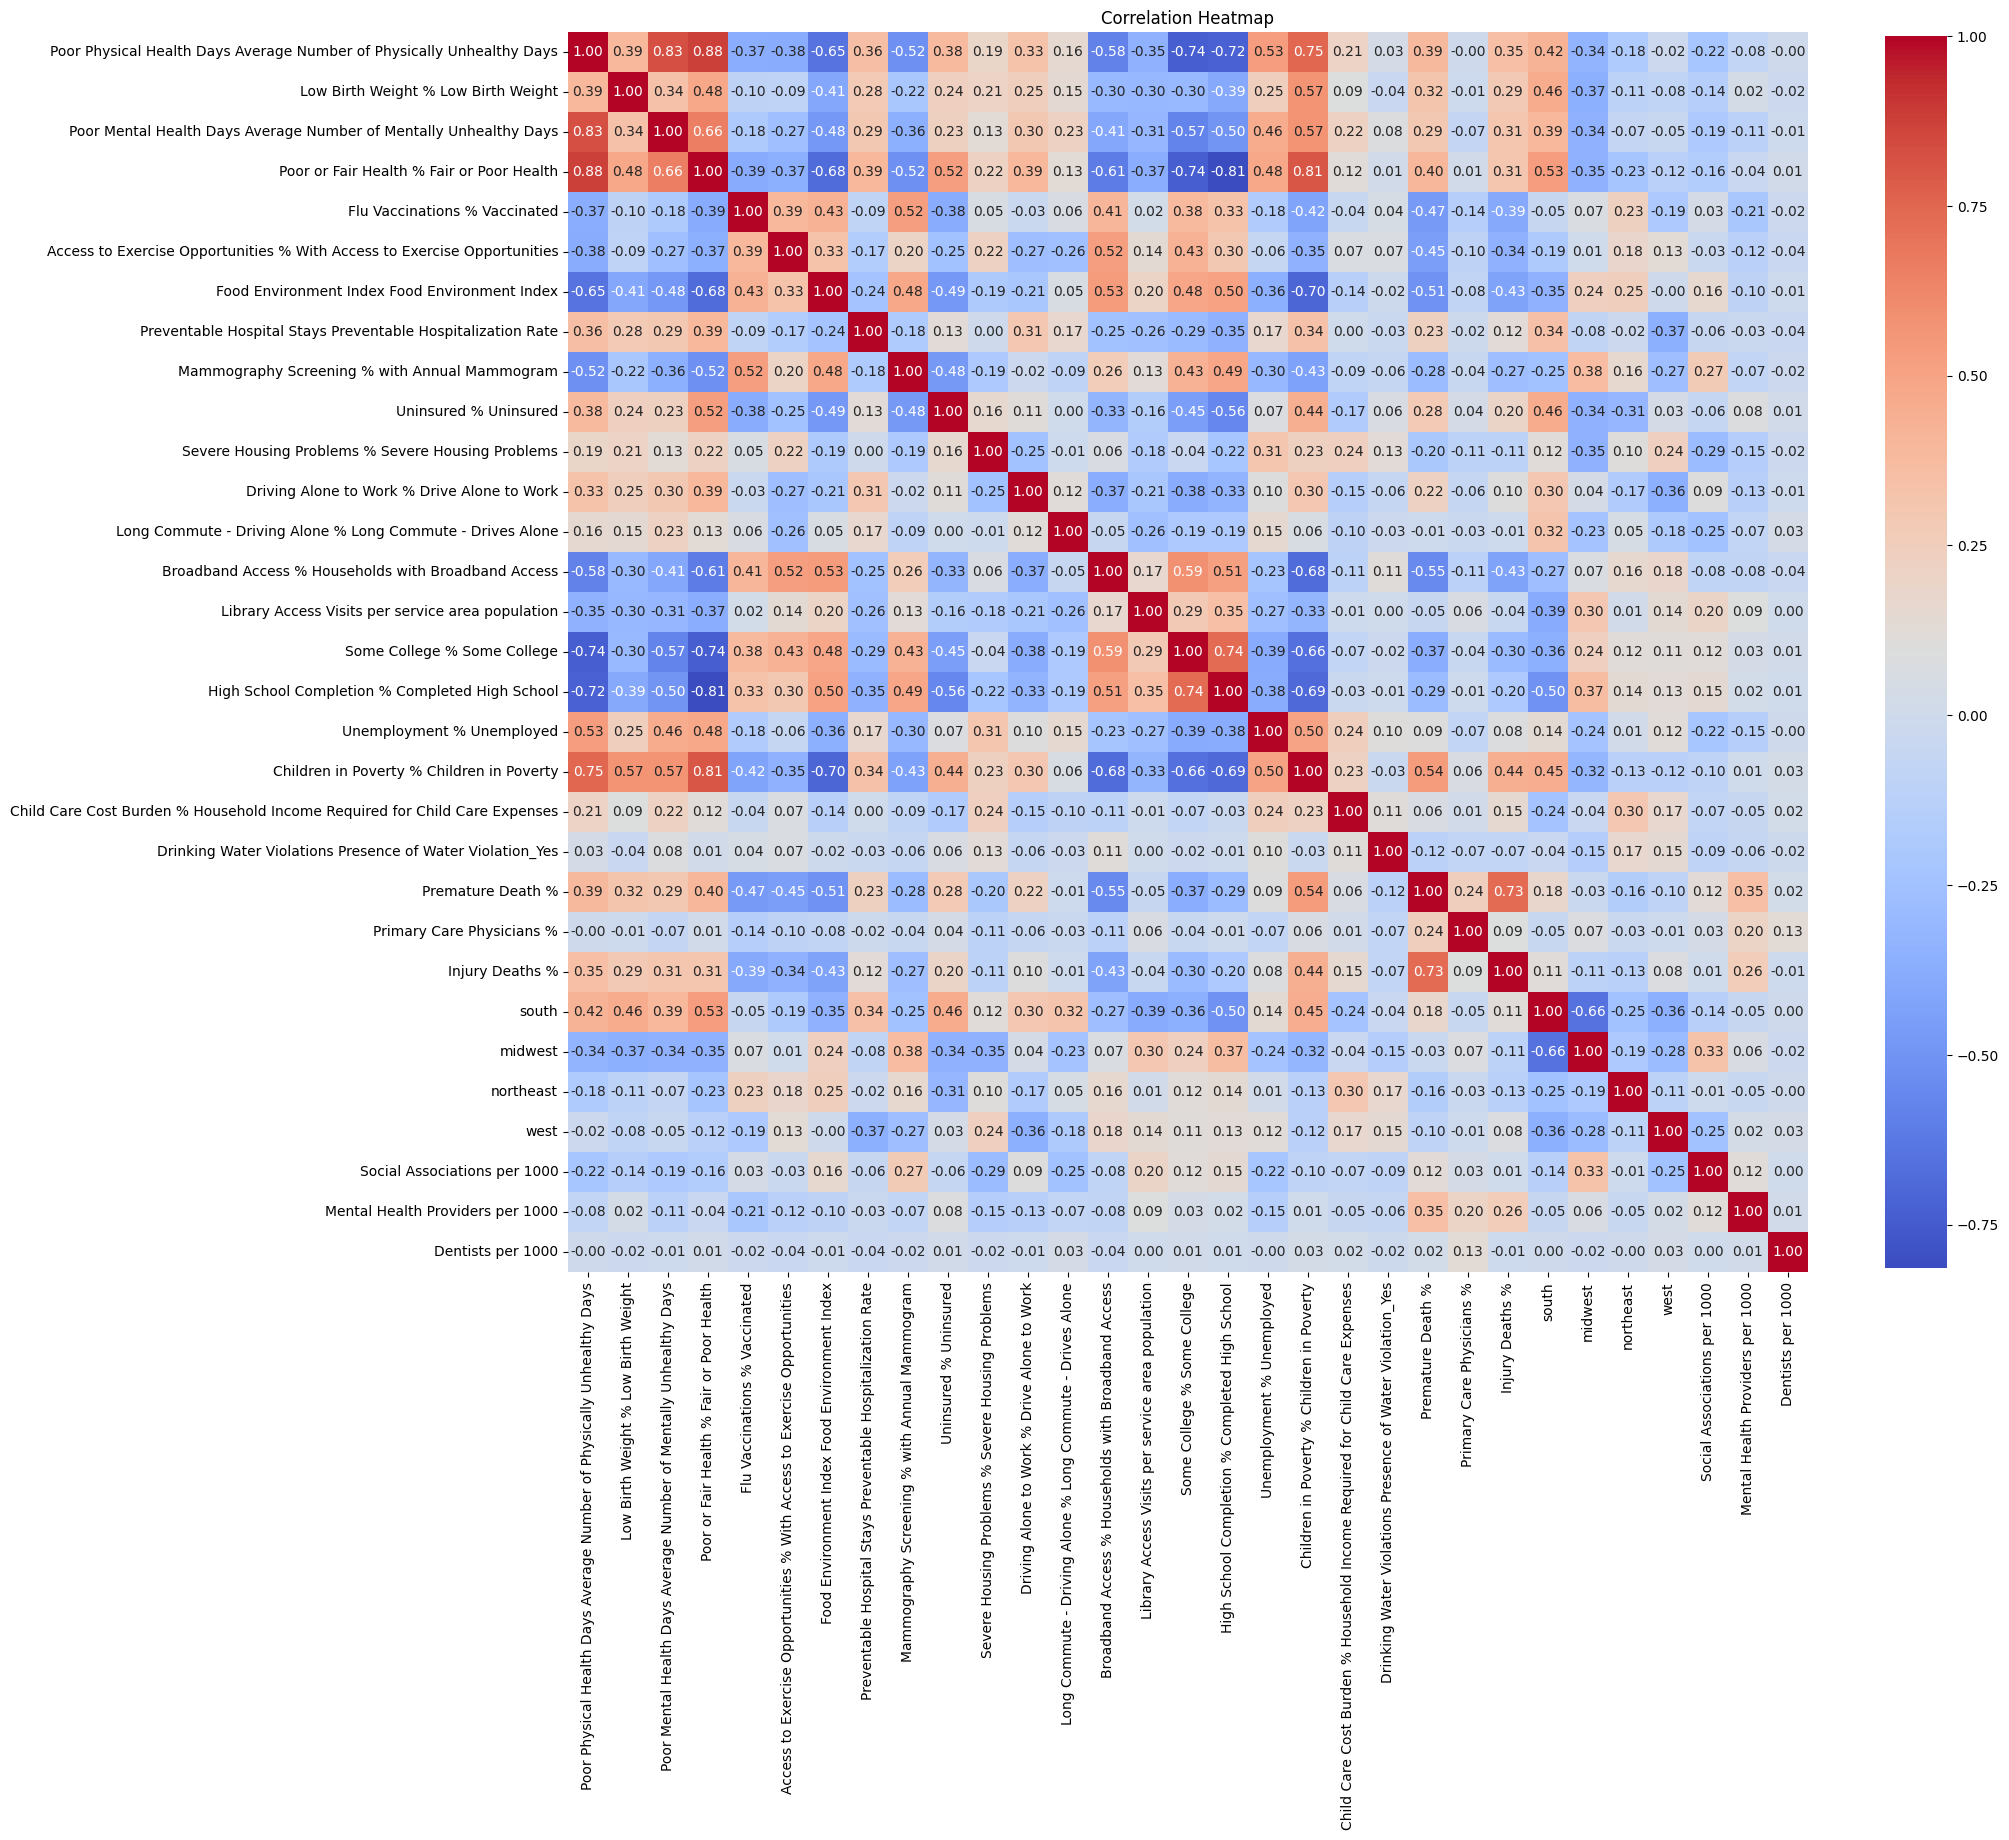

In [35]:
#Create a heatmap to visualize the correlation between the columns
plt.figure(figsize=(20, 20))
import seaborn as sns
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

In [36]:
X_train

,Poor Physical Health Days Average Number of Physically Unhealthy Days,Low Birth Weight % Low Birth Weight,Poor Mental Health Days Average Number of Mentally Unhealthy Days,Poor or Fair Health % Fair or Poor Health,Flu Vaccinations % Vaccinated,Access to Exercise Opportunities % With Access to Exercise Opportunities,Food Environment Index Food Environment Index,Preventable Hospital Stays Preventable Hospitalization Rate,Mammography Screening % with Annual Mammogram,Uninsured % Uninsured,Severe Housing Problems % Severe Housing Problems,Driving Alone to Work % Drive Alone to Work,Long Commute - Driving Alone % Long Commute - Drives Alone,Broadband Access % Households with Broadband Access,Library Access Visits per service area population,Some College % Some College,High School Completion % Completed High School,Unemployment % Unemployed,Children in Poverty % Children in Poverty,Child Care Cost Burden % Household Income Required for Child Care Expenses,Drinking Water Violations Presence of Water Violation_Yes,Premature Death %,Primary Care Physicians %,Injury Deaths %,south,midwest,northeast,west,Social Associations per 1000,Mental Health Providers per 1000,Dentists per 1000
2936,4.967534,-2.869120,0.594093,-1.686668,0.51,0.871915,0.326251,0.592938,0.48,-2.619844,-1.537673,0.447164,0.160,0.246130,0.638838,0.577074,0.450661,-3.193293,-1.002653,-1.307156,False,0.734676,0.000660,-113.881567,1,0,0,0,0.303796,0.004079,0.019024
840,3.868272,-3.638496,0.329035,-2.016090,0.39,0.499726,0.680880,0.536896,0.58,-3.034086,-1.767312,0.423865,0.191,0.483959,0.592782,0.679350,0.673042,-3.550150,-1.596479,-1.420733,False,0.595077,0.000486,-156.007890,0,1,0,0,0.320394,0.001846,0.029340
1174,5.298902,-2.646579,0.675128,-1.426540,0.30,0.214727,0.451358,0.807907,0.39,-2.484120,-1.743806,0.735535,0.344,0.094192,0.413430,0.381755,0.276113,-2.696097,-1.019199,-1.142908,True,0.732658,0.000537,-103.412250,1,0,0,0,0.320042,0.001906,0.011357
1618,3.434077,-3.067557,0.329064,-2.307918,0.50,0.812066,0.785850,0.342289,0.48,-2.606006,-1.536396,0.237647,0.160,0.663194,0.473241,0.803054,0.811441,-3.705866,-1.980436,-1.218894,False,0.157852,0.000762,-225.499590,0,0,0,1,0.173851,0.014155,0.036511
2656,4.399847,-2.917604,0.505733,-1.720587,0.40,0.494654,0.421283,0.648144,0.42,-1.702657,-1.417491,0.427998,0.434,0.511064,0.390237,0.555324,0.345625,-3.077812,-1.401754,-1.252284,True,0.627325,0.000246,-179.914865,1,0,0,0,0.140089,0.002521,0.015796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,4.204037,-3.066020,0.459466,-1.709161,0.53,0.546852,0.680880,0.250364,0.53,-2.523188,-1.694305,0.381503,0.348,0.389680,0.576921,0.602112,0.526518,-3.256983,-1.493306,-1.076210,False,0.590057,0.000824,-140.138027,0,1,0,0,0.222434,0.003045,0.029939
1095,5.281015,-2.950392,0.466111,-1.311452,0.30,0.512240,0.406743,0.484014,0.45,-2.675421,-1.716952,0.626039,0.255,0.330900,0.452279,0.519098,0.233365,-2.841818,-1.151746,-1.517150,True,0.723387,0.000382,-120.542711,1,0,0,0,0.138291,0.005651,0.014433
1130,6.396404,-2.082933,0.744400,-1.070062,0.17,0.783177,0.119918,0.904969,0.46,-2.510135,-1.319717,0.422769,0.168,0.126549,0.383116,0.285644,0.059521,-2.367959,-0.586163,-0.843799,True,0.737940,0.000436,-145.098050,1,0,0,0,0.129901,0.015470,0.015365
1294,4.481129,-2.989901,0.478060,-1.881385,0.32,0.738981,0.532499,0.448347,0.47,-2.746344,-1.627946,0.406566,0.440,0.378960,0.506755,0.541509,0.457728,-3.042055,-1.373323,-1.297708,False,0.600374,0.000352,-125.969021,0,1,0,0,0.183295,0.006641,0.029940
